# Generate routes

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [2]:
data_stops = pd.read_csv('uni_molde_v2.csv', sep=',')

data_stops
data_stops.loc[data_stops['stop_completed_at'].isna(), 'stop_completed_at'] = "-1"
data_stops.loc[data_stops['stop_arrived_at'].isna(), 'stop_arrived_at'] = "-1"

print(data_stops.isnull().sum())


sorted_data_stops = data_stops.sort_values(by='stop_dispatched_at', ascending=True)
sorted_data_stops = sorted_data_stops.reset_index(drop=True)
sorted_data_stops['day_of_week'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.day_name()
sorted_data_stops['date'] = pd.to_datetime(sorted_data_stops['stop_dispatched_at']).dt.date

#clustering
locations_df = sorted_data_stops[['current_lat', 'current_lng']]
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit(locations_df)
sorted_data_stops['cluster'] = kmeans.labels_ + 1

sorted_data_stops['location_id_craft'] = sorted_data_stops.groupby(['current_lat', 'current_lng']).ngroup()+1
with open('output.txt', 'w') as f:
    print(sorted_data_stops.to_string(), file=f)
print('number of groups', sorted_data_stops['location_id_craft'].nunique())

# data_stops_day= sorted_data_stops[sorted_data_stops['day_of_week'] == "Wednesday"]
grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'address_id', 'stop_dispatched_at', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'stop_completed_at', 'cluster', 'location_id_craft','day_of_week', 'date']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'planned_route_location': x['address_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
    'current_lat': x['current_lat'].tolist(),
    'current_lng': x['current_lng'].tolist(),
    'stop_completed_at': x['stop_completed_at'].tolist(),
    'planned_route_cluster': x['cluster'].tolist(),
    'planned_route_craft': x['location_id_craft'].tolist(),
    'day_of_week': x['day_of_week'].tolist(),
    'date': x['date'].tolist()
})).reset_index()

stop_completed_at        0
stop_arrived_at          0
stop_latest              0
stop_earliest            0
stop_dispatched_at       0
location_id              0
location_type_id         0
driver_workday_id        0
organization_id          0
address_id               0
location_is_depot        0
driver_id                0
contact_id               0
current_lat              0
current_lng              0
prev_planned_lat      7450
prev_planned_lng      7450
prev_actual_lat       7450
prev_actual_lng       7450
dtype: int64
number of groups 3110


In [3]:
from geopy.distance import geodesic
import pandas as pd

# Function to calculate distance between two coordinates
def calculate_distance(row):
    distances = []
    for i in range(len(row['planned_route_craft'])-1):
        coords_1 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lng']].values[0][0])
        coords_2 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lng']].values[0][0])
        distances.append(geodesic(coords_1, coords_2).miles)
    return distances

# Create a new column 'distance_route' in 'final_routes'
grouped_df['distance_route'] = grouped_df.apply(calculate_distance, axis=1)

In [4]:
grouped_df

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route
0,297900,"[1255, 1255, 1255, 1255, 1255, 1255, 1255, 125...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 118973, 118854, 118820, 118623, 11909...","[2024-01-01 19:41:35.136881+00, 2024-01-01 19:...","[2024-01-01 22:14:16.454324+00, 2024-01-01 23:...","[2024-01-01 19:00:00+00, 2024-01-01 23:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 03:00:00+0...","[55.647, 55.667, 55.677, 55.676, 55.671, 55.66...","[12.152, 12.526, 12.566, 12.562, 12.561, 12.56...","[2024-01-01 22:14:54.872731+00, 2024-01-01 23:...","[766, 597, 919, 560, 560, 404, 811, 404, 404, ...","[886, 1060, 1171, 1160, 1098, 1057, 1078, 1065...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[14.693059943223329, 1.7100561195423718, 0.170..."
1,297906,"[1195, 1195, 1195, 1195, 1195, 1195, 1195]","[1, 2, 2, 2, 2, 2, 2]","[122267, 120295, 120297, 118930, 120298, 13328...","[2024-01-01 19:42:05.147145+00, 2024-01-01 19:...","[2024-01-01 20:50:17.003744+00, 2024-01-02 02:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.662, 55.662, 55.673, 55.662, 55.65...","[12.152, 12.361, 12.363, 12.394, 12.369, 12.36...","[2024-01-01 20:50:29.721122+00, 2024-01-02 02:...","[766, 723, 723, 263, 116, 116, 416]","[886, 1018, 1019, 1116, 1020, 989, 1051]","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[8.240469050783075, 0.0782134907119265, 1.4312..."
2,297908,"[1176, 1176, 1176, 1176, 1176, 1176, 1176, 117...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[122267, 120515, 119217, 119215, 119170, 13445...","[2024-01-01 21:25:47.230131+00, 2024-01-01 21:...","[2024-01-01 23:06:27.627368+00, 2024-01-02 01:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.62, 55.636, 55.632, 55.627, 55.609...","[12.152, 12.029, 12.045, 12.055, 12.097, 12.08...","[2024-01-01 23:06:36.064172+00, 2024-01-02 01:...","[766, 625, 785, 376, 506, 626, 854, 854, 854, ...","[886, 721, 790, 772, 737, 695, 970, 970, 960, ...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[5.163323971103205, 1.2717651170406523, 0.4792..."
3,297911,"[1197, 1197, 1197, 1197, 1197, 1197, 1197, 119...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 145327, 133259, 133259, 133259, 13325...","[2024-01-01 19:42:59.704147+00, 2024-01-01 19:...","[2024-01-02 00:09:15.241119+00, 2024-01-02 04:...","[2024-01-02 00:00:00+00, 2024-01-02 04:30:00+0...","[2024-01-02 22:00:00+00, 2024-01-02 08:00:00+0...","[55.647, 54.651, 54.666, 54.666, 54.666, 54.66...","[12.152, 11.376, 11.333, 11.333, 11.333, 11.33...","[2024-01-02 00:09:21.131516+00, 2024-01-02 04:...","[766, 188, 39, 39, 39, 39, 39, 39, 957, 188]","[886, 5, 20, 20, 20, 20, 20, 20, 10, 3]","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[75.44459145823315, 2.0124277859574424, 0.0, 0..."
4,297919,"[1218, 1218, 1218, 1218, 1218, 1218, 1218, 121...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 119426, 118790, 119069, 118805, 11885...","[2024-01-01 19:46:51.16173+00, 2024-01-01 19:4...","[2024-01-01 23:05:52.039818+00, 2024-01-02 01:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.623, 55.562, 55.638, 55.681, 55.64...","[12.152, 12.616, 12.577, 12.652, 12.605, 12.54...","[2024-01-01 23:05:58.283704+00, 2024-01-02 01:...","[766, 687, 160, 829, 386, 408, 408, 843, 348, ...","[886, 726, 624, 808, 1226, 891, 880, 678, 651,...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 20

In [5]:
routes = grouped_df[grouped_df.apply(lambda row: max(row['stop_dispatched_at']) < min(row['stop_completed_at']), axis=1)]
routes = routes.reset_index(drop=True)
len(routes)

5299

In [6]:
index_routes_with_na = []
for i in range(len(routes)):
    row = routes.iloc[i]
    if "-1" in row['stop_arrived_at']:
        index_routes_with_na.append(i)
print("The number of routes where one value is NA(arrived time)", len(index_routes_with_na))
print(index_routes_with_na)
routes = routes.drop(index_routes_with_na)
routes.reset_index(drop=True)

The number of routes where one value is NA(arrived time) 15
[828, 932, 1130, 1750, 1941, 2216, 2444, 2502, 2524, 2534, 2720, 2839, 3202, 3761, 5276]


,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route
0,297900,"[1255, 1255, 1255, 1255, 1255, 1255, 1255, 125...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 118973, 118854, 118820, 118623, 11909...","[2024-01-01 19:41:35.136881+00, 2024-01-01 19:...","[2024-01-01 22:14:16.454324+00, 2024-01-01 23:...","[2024-01-01 19:00:00+00, 2024-01-01 23:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 03:00:00+0...","[55.647, 55.667, 55.677, 55.676, 55.671, 55.66...","[12.152, 12.526, 12.566, 12.562, 12.561, 12.56...","[2024-01-01 22:14:54.872731+00, 2024-01-01 23:...","[766, 597, 919, 560, 560, 404, 811, 404, 404, ...","[886, 1060, 1171, 1160, 1098, 1057, 1078, 1065...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[14.693059943223329, 1.7100561195423718, 0.170..."
1,297906,"[1195, 1195, 1195, 1195, 1195, 1195, 1195]","[1, 2, 2, 2, 2, 2, 2]","[122267, 120295, 120297, 118930, 120298, 13328...","[2024-01-01 19:42:05.147145+00, 2024-01-01 19:...","[2024-01-01 20:50:17.003744+00, 2024-01-02 02:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.662, 55.662, 55.673, 55.662, 55.65...","[12.152, 12.361, 12.363, 12.394, 12.369, 12.36...","[2024-01-01 20:50:29.721122+00, 2024-01-02 02:...","[766, 723, 723, 263, 116, 116, 416]","[886, 1018, 1019, 1116, 1020, 989, 1051]","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[8.240469050783075, 0.0782134907119265, 1.4312..."
2,297911,"[1197, 1197, 1197, 1197, 1197, 1197, 1197, 119...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 145327, 133259, 133259, 133259, 13325...","[2024-01-01 19:42:59.704147+00, 2024-01-01 19:...","[2024-01-02 00:09:15.241119+00, 2024-01-02 04:...","[2024-01-02 00:00:00+00, 2024-01-02 04:30:00+0...","[2024-01-02 22:00:00+00, 2024-01-02 08:00:00+0...","[55.647, 54.651, 54.666, 54.666, 54.666, 54.66...","[12.152, 11.376, 11.333, 11.333, 11.333, 11.33...","[2024-01-02 00:09:21.131516+00, 2024-01-02 04:...","[766, 188, 39, 39, 39, 39, 39, 39, 957, 188]","[886, 5, 20, 20, 20, 20, 20, 20, 10, 3]","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[75.44459145823315, 2.0124277859574424, 0.0, 0..."
3,297919,"[1218, 1218, 1218, 1218, 1218, 1218, 1218, 121...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 119426, 118790, 119069, 118805, 11885...","[2024-01-01 19:46:51.16173+00, 2024-01-01 19:4...","[2024-01-01 23:05:52.039818+00, 2024-01-02 01:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.623, 55.562, 55.638, 55.681, 55.64...","[12.152, 12.616, 12.577, 12.652, 12.605, 12.54...","[2024-01-01 23:05:58.283704+00, 2024-01-02 01:...","[766, 687, 160, 829, 386, 408, 408, 843, 348, ...","[886, 726, 624, 808, 1226, 891, 880, 678, 651,...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[18.233734262602088, 4.488050072595194, 6.0227..."
4,297922,"[1192, 1192, 1192, 1192, 1192, 1192, 1192, 119...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 119416, 119195, 119179, 119149, 11918...","[2024-01-01 19:36:39.7416+00, 2024-01-01 19:36...","[2024-01-01 23:00:15.671794+00, 2024-01-01 23:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.646, 55.653, 55.655, 55.649, 55.64...","[12.152, 12.119, 12.126, 12.093, 12.07, 12.071...","[2024-01-01 23:00:27.463553+00, 2024-01-01 23:...","[766, 549, 173, 628, 495, 495, 495, 268, 268, ...","[886, 876, 952, 969, 906, 907, 874, 833, 814, ...","[Monday, Monday, Monday, Monday, Monday, Monda...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-0

In [7]:
#check if it is the same driver in the route
for i in routes['driver_id']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')
routes['driver_id'] = routes['driver_id'].apply(lambda x : x[0])

routes['day_of_week'] = routes['day_of_week'].apply(lambda x : x[0])
routes['date'] = routes['date'].apply(lambda x : x[0])

routes['date'] = pd.to_datetime(routes['date'])
routes['last_two_weeks_count'] = routes.apply(lambda row:
                                      routes[(routes['driver_id'] == row['driver_id']) &
                                         (row['date'] - routes['date']).dt.days.between(-14, 0)].shape[0],
                                      axis=1)
routes = routes[(routes['date'] < '2024-01-01') | (routes['date'] > '2024-01-14')]

In [8]:
routes

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route,last_two_weeks_count
466,305735,1255,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 118973, 118820, 119089, 118814, 11909...","[2024-01-15 20:13:10.25734+00, 2024-01-15 20:1...","[2024-01-15 22:11:49.528537+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 23:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 03:00:00+0...","[55.646, 55.667, 55.676, 55.667, 55.666, 55.66...","[12.154, 12.526, 12.562, 12.567, 12.565, 12.56...","[2024-01-15 22:14:55.135437+00, 2024-01-15 23:...","[4, 597, 560, 404, 404, 404, 811, 925]","[878, 1060, 1160, 1065, 1057, 1057, 1078, 965]",Monday,2024-01-15,"[14.622082174286605, 1.5390669065648581, 0.652...",8
470,305741,1195,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 120295, 133280, 120297, 118930, 11893...","[2024-01-15 20:14:10.430711+00, 2024-01-15 20:...","[2024-01-15 22:58:58.038139+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.662, 55.658, 55.662, 55.673, 55.67...","[12.154, 12.361, 12.369, 12.363, 12.394, 12.39...","[2024-01-15 22:59:10.867219+00, 2024-01-15 23:...","[4, 723, 116, 723, 263, 263, 263, 416]","[878, 1018, 989, 1019, 1116, 1116, 1198, 1051]",Monday,2024-01-15,"[8.172054329806356, 0.4176879391889399, 0.3628...",11
471,305742,1186,"[1, 2, 2, 2, 2, 2, 2]","[153184, 118945, 119107, 119964, 126319, 12031...","[2024-01-15 20:15:12.147596+00, 2024-01-15 20:...","[2024-01-15 22:32:42.615543+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.75, 55.801, 55.779, 55.766, 55.858...","[12.154, 12.587, 12.526, 12.524, 12.504, 12.39...","[2024-01-15 22:32:54.670991+00, 2024-01-15 23:...","[4, 545, 179, 373, 76, 271, 346]","[878, 1567, 1706, 1660, 1613, 1857, 1777]",Monday,2024-01-15,"[18.384015293331288, 4.255179313348523, 1.5240...",9
476,305754,1218,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118858, 119855, 118805, 119069, 11879...","[2024-01-15 20:17:12.871538+00, 2024-01-15 20:...","[2024-01-15 22:37:07.860851+00, 2024-01-16 00:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.647, 55.672, 55.681, 55.638, 55.56...","[12.154, 12.54, 12.589, 12.605, 12.652, 12.577...","[2024-01-15 22:37:19.03627+00, 2024-01-16 00:2...","[4, 408, 666, 386, 829, 160, 687, 180, 245, 421]","[878, 891, 1114, 1226, 808, 624, 726, 706, 628...",Monday,2024-01-15,"[15.101307234678234, 2.581403110353377, 0.8825...",11
480,305758,1192,"[1, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118509, 144815, 119179, 118785, 11928...","[2024-01-15 20:17:36.851051+00, 2024-01-15 20:...","[2024-01-15 23:06:33.822316+00, 2024-01-16 01:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.64, 55.639, 55.655, 55.641, 55.64,...","[12.154, 12.091, 12.063, 12.093, 12.08, 12.088...","[2024-01-15 23:06:46.892607+00, 2024-01-16 01:...","[4, 595, 837, 628, 268, 595, 141, 173, 844]","[878, 828, 810, 969, 836, 825, 638, 952, 996]",Monday,2024-01-15,"[2.4996231048871693, 1.097798850741114, 1.6132...",11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,378091,1183,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118722, 118722, 118949, 118837, 11938...","[2024-04-27 02:07:20.988692+00, 2024-04-27 02:...","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 11:00:00+0...","[55.646, 55.814, 55.814, 55.748, 55.885, 55.97...","[12.154, 12.377, 12.377, 12.541, 12.547, 12.53...","[2024-04-27 02:10:37.02229+00, 2024-04-27 02:4...","[4, 165, 165, 250, 477, 384, 121, 18, 214, 214]","[878, 1725, 1725, 1559, 

In [9]:
def create_actual_route(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(sorted_dates):
            mapping[date] = row[column][i]
        res_val = [mapping[row['stop_arrived_at'][i]] for i in range(len(row['stop_arrived_at']))]
        res_col.append(res_val)
    return res_col

routes['actual_route_location'] = create_actual_route(routes, 'planned_route_craft')
routes.to_csv('routes.csv', sep=';')
routes

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route,last_two_weeks_count,actual_route_location
466,305735,1255,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 118973, 118820, 119089, 118814, 11909...","[2024-01-15 20:13:10.25734+00, 2024-01-15 20:1...","[2024-01-15 22:11:49.528537+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 23:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 03:00:00+0...","[55.646, 55.667, 55.676, 55.667, 55.666, 55.66...","[12.154, 12.526, 12.562, 12.567, 12.565, 12.56...","[2024-01-15 22:14:55.135437+00, 2024-01-15 23:...","[4, 597, 560, 404, 404, 404, 811, 925]","[878, 1060, 1160, 1065, 1057, 1057, 1078, 965]",Monday,2024-01-15,"[14.622082174286605, 1.5390669065648581, 0.652...",8,"[878, 1060, 1160, 1065, 1057, 1057, 1078, 965]"
470,305741,1195,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 120295, 133280, 120297, 118930, 11893...","[2024-01-15 20:14:10.430711+00, 2024-01-15 20:...","[2024-01-15 22:58:58.038139+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.662, 55.658, 55.662, 55.673, 55.67...","[12.154, 12.361, 12.369, 12.363, 12.394, 12.39...","[2024-01-15 22:59:10.867219+00, 2024-01-15 23:...","[4, 723, 116, 723, 263, 263, 263, 416]","[878, 1018, 989, 1019, 1116, 1116, 1198, 1051]",Monday,2024-01-15,"[8.172054329806356, 0.4176879391889399, 0.3628...",11,"[878, 989, 1019, 1018, 1116, 1116, 1198, 1051]"
471,305742,1186,"[1, 2, 2, 2, 2, 2, 2]","[153184, 118945, 119107, 119964, 126319, 12031...","[2024-01-15 20:15:12.147596+00, 2024-01-15 20:...","[2024-01-15 22:32:42.615543+00, 2024-01-15 23:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.75, 55.801, 55.779, 55.766, 55.858...","[12.154, 12.587, 12.526, 12.524, 12.504, 12.39...","[2024-01-15 22:32:54.670991+00, 2024-01-15 23:...","[4, 545, 179, 373, 76, 271, 346]","[878, 1567, 1706, 1660, 1613, 1857, 1777]",Monday,2024-01-15,"[18.384015293331288, 4.255179313348523, 1.5240...",9,"[878, 1567, 1660, 1706, 1613, 1777, 1857]"
476,305754,1218,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118858, 119855, 118805, 119069, 11879...","[2024-01-15 20:17:12.871538+00, 2024-01-15 20:...","[2024-01-15 22:37:07.860851+00, 2024-01-16 00:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.647, 55.672, 55.681, 55.638, 55.56...","[12.154, 12.54, 12.589, 12.605, 12.652, 12.577...","[2024-01-15 22:37:19.03627+00, 2024-01-16 00:2...","[4, 408, 666, 386, 829, 160, 687, 180, 245, 421]","[878, 891, 1114, 1226, 808, 624, 726, 706, 628...",Monday,2024-01-15,"[15.101307234678234, 2.581403110353377, 0.8825...",11,"[878, 808, 706, 628, 724, 726, 624, 1226, 1114..."
480,305758,1192,"[1, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118509, 144815, 119179, 118785, 11928...","[2024-01-15 20:17:36.851051+00, 2024-01-15 20:...","[2024-01-15 23:06:33.822316+00, 2024-01-16 01:...","[2024-01-15 19:00:00+00, 2024-01-15 21:00:00+0...","[2024-01-16 01:00:00+00, 2024-01-16 04:00:00+0...","[55.646, 55.64, 55.639, 55.655, 55.641, 55.64,...","[12.154, 12.091, 12.063, 12.093, 12.08, 12.088...","[2024-01-15 23:06:46.892607+00, 2024-01-16 01:...","[4, 595, 837, 628, 268, 595, 141, 173, 844]","[878, 828, 810, 969, 836, 825, 638, 952, 996]",Monday,2024-01-15,"[2.4996231048871693, 1.097798850741114, 1.6132...",11,"[878, 825, 996, 969, 952, 638, 836, 810, 828]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,378091,1183,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118722, 118722, 118949, 118837, 11938...","[2024-04-27 02:07:20.988692+00, 2024-04-27 02:...","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:00+0...","[2024-04-27 21

In [10]:
planned_routes = routes[['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng']]
actual_routes = routes['actual_route_location']

In [11]:
planned_routes_list = planned_routes['planned_route_craft'].tolist()
actual_routes_list = actual_routes.tolist()

# filtered_rows = []
#
# for row in actual_routes_list:
#     if row not in planned_routes_list:
#         filtered_rows.append(row)

#duplicated removed
# planned_routes_list = [array for i, array in enumerate(planned_routes_list) if array not in planned_routes_list[:i]]
# actual_routes_list = [array for i, array in enumerate(filtered_rows) if array not in filtered_rows[:i]]
len(planned_routes_list),len(actual_routes_list)

(4740, 4740)

# Edit distance

In [12]:
# Edit Distance

def minDistance(word1, word2) -> int:
    m = len(word1)
    n = len(word2)
    # dp[i][j] := min # Of operations to convert word1[0..i) to word2[0..j)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
      dp[i][0] = i

    for j in range(1, n + 1):
      dp[0][j] = j

    for i in range(1, m + 1):
      for j in range(1, n + 1):
        if word1[i - 1] == word2[j - 1]:
          dp[i][j] = dp[i - 1][j - 1]
        else:
          dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    return dp[m][n]


For each driver-day, we consider only the planned route. For each planned route we calculate how much it deviates from the actual route (e.g., use some form of edit distance - see https://link.springer.com/article/10.1007/s10732-006-9001-3?), which is then normalized (divide by max edit distance, or number of visits or something?) to the interval [0, 1]. Then, a planned route is good if this distance (between planned and actual) is less than a certain threshold and otherwise it is bad. This becomes the label (bad/good)

In [158]:
completed_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng'])
uncompleted_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng'])
#11700795
for i in range(len(planned_routes_list)):
    if minDistance(planned_routes_list[i],actual_routes_list[i]) < min(len(planned_routes_list[i])/2, 7):
        completed_routes_df = pd.concat([completed_routes_df, pd.DataFrame([planned_routes.iloc[i]]).reset_index(drop=True)], ignore_index=True)
    else:
        uncompleted_routes_df = pd.concat([uncompleted_routes_df, pd.DataFrame([planned_routes.iloc[i]]).reset_index(drop=True)], ignore_index=True)

uncompleted_routes_df.to_csv('uncompleted_routes_df.txt', index=False)


In [ ]:
import folium
import math

lat_seq = completed_routes_df['current_lat'][0]
lon_seq = completed_routes_df['current_lng'][0]

print(lat_seq, lon_seq)

def build_route(lat_seq, lon_seq):
    m = folium.Map(location=[lat_seq[0], lon_seq[0]], zoom_start=13)

    # Add a polyline with arrows
    for i in range(len(lat_seq)):
        lat, lon = lat_seq[i], lon_seq[i]

        # Add an index label
        folium.Marker([lat, lon], icon=folium.DivIcon(html=f'<div style="font-size: 13pt; border: 2px solid white; border-radius: 50%; padding: 2px; background-color: white">{i+1}</div>')).add_to(m)

        if i < len(lat_seq) - 1:
            next_lat, next_lon = lat_seq[i + 1], lon_seq[i + 1]
            angle = np.rad2deg(np.arctan2(next_lat - lat, next_lon - lon))
            arrow_lon = lon + 0.001 * np.cos(np.deg2rad(angle))

            # Add a line segment
            folium.PolyLine([[lat, lon], [next_lat, next_lon]], color='blue', dash_array='5, 5').add_to(m)

            # Add an arrow at the end of the line segment
            folium.Marker([next_lat, next_lon], icon=folium.Icon(color='blue', icon='arrow-up', prefix='fa')).add_to(m)

    m.save('route_map.html')

In [159]:

# uncompleted_routes_df = uncompleted_routes_df.sample(n=len(completed_routes_df), random_state=42)
len(completed_routes_df), len(uncompleted_routes_df)
# completed_routes_df

(2225, 2515)

In [160]:
# completed_routes_list_unique = [array for i, array in enumerate(completed_routes_list) if array not in completed_routes_list[:i]]
# uncompleted_routes_list_unique = [array for i, array in enumerate(uncompleted_routes_list) if array not in uncompleted_routes_list[:i]]
# len(completed_routes_list_unique), len (uncompleted_routes_list_unique)
# len(completed_routes_df), len(uncompleted_routes_df)

In [161]:
final_routes = pd.DataFrame({
    'routes': completed_routes_df['planned_route_craft'].tolist() + uncompleted_routes_df['planned_route_craft'].tolist(),
    'driver_id': completed_routes_df['driver_id'].tolist() +  uncompleted_routes_df['driver_id'].tolist(),
    'distance_route': completed_routes_df['distance_route'].tolist() + uncompleted_routes_df['distance_route'].tolist(),
    'last_two_weeks_count': completed_routes_df['last_two_weeks_count'].tolist() + uncompleted_routes_df['last_two_weeks_count'].tolist(),
    # 'day_of_week': completed_routes_df['day_of_week'].tolist() + uncompleted_routes_df['day_of_week'].tolist(),
    'label': [0] * len(completed_routes_df)  + [1] * len(uncompleted_routes_df)
})
final_routes['len'] = final_routes['routes'].apply(lambda x: len(x))
final_routes

# [0] * len(artificial_planned_routes)
# artificial_planned_routes['distance_route'].tolist()
# artificial_planned_routes['driver_id'].tolist()
# artificial_planned_routes['common_subsequence'].tolist()

,routes,driver_id,distance_route,last_two_weeks_count,label,len
0,"[878, 1060, 1160, 1065, 1057, 1057, 1078, 965]",1255,"[14.622082174286605, 1.5390669065648581, 0.652...",8,0,8
1,"[878, 1018, 989, 1019, 1116, 1116, 1198, 1051]",1195,"[8.172054329806356, 0.4176879391889399, 0.3628...",11,0,8
2,"[878, 1394, 1394, 1297, 1313, 1321, 1395, 1402...",1198,"[15.839195062452609, 0.0, 1.5095405869966783, ...",8,0,14
3,"[878, 708]",1197,[13.46312743323789],2,0,2
4,"[878, 1060, 1098, 1160, 1065, 1057, 1057, 1078...",1255,"[14.622082174286605, 1.3961896890494718, 0.348...",7,0,9
...,...,...,...,...,...,...
4735,"[2294, 1712, 1648, 1648, 1404, 1405, 1409, 141...",1632,"[18.177061806353283, 3.942687064958281, 0.0, 6...",1,1,22
4736,"[878, 878, 825, 811, 783, 951, 957, 773, 787, ...",1489,"[0.0, 2.6154431091709953, 0.9416449007718006, ...",1,1,20
4737,"[2294, 2311, 2397, 2439, 2652, 2643, 2660, 271...",1516,"[1.7906326010914968, 5.099724963464688, 2.2459...",1,1,22
4738,"[878, 172, 175, 175, 174, 162, 173, 177, 157, ...",1217,"[46.214479514984745, 0.07979642559311469, 0.0,...",1,1,10


In [162]:

max([len(i) for i in final_routes['routes']])

35

In [163]:
#create dictionary and encode to smaller unique numbers
locations_dic = {}
location_count = {}
k = 0
for row in final_routes['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1

print(len(locations_dic))

for row in final_routes['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1


2965


In [164]:
drivers_dic = {}
k = 1
for driver in final_routes['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)
final_routes

Total number of drivers 191


,routes,driver_id,distance_route,last_two_weeks_count,label,len,driver_id_sorted
0,"[878, 1060, 1160, 1065, 1057, 1057, 1078, 965]",1255,"[14.622082174286605, 1.5390669065648581, 0.652...",8,0,8,1
1,"[878, 1018, 989, 1019, 1116, 1116, 1198, 1051]",1195,"[8.172054329806356, 0.4176879391889399, 0.3628...",11,0,8,2
2,"[878, 1394, 1394, 1297, 1313, 1321, 1395, 1402...",1198,"[15.839195062452609, 0.0, 1.5095405869966783, ...",8,0,14,3
3,"[878, 708]",1197,[13.46312743323789],2,0,2,4
4,"[878, 1060, 1098, 1160, 1065, 1057, 1057, 1078...",1255,"[14.622082174286605, 1.3961896890494718, 0.348...",7,0,9,1
...,...,...,...,...,...,...,...
4735,"[2294, 1712, 1648, 1648, 1404, 1405, 1409, 141...",1632,"[18.177061806353283, 3.942687064958281, 0.0, 6...",1,1,22,191
4736,"[878, 878, 825, 811, 783, 951, 957, 773, 787, ...",1489,"[0.0, 2.6154431091709953, 0.9416449007718006, ...",1,1,20,76
4737,"[2294, 2311, 2397, 2439, 2652, 2643, 2660, 271...",1516,"[1.7906326010914968, 5.099724963464688, 2.2459...",1,1,22,146
4738,"[878, 172, 175, 175, 174, 162, 173, 177, 157, ...",1217,"[46.214479514984745, 0.07979642559311469, 0.0,...",1,1,10,40


In [165]:
final_routes['experience_feature'] = final_routes.apply(lambda x: x['len'] * [x['last_two_weeks_count']], axis = 1)
final_routes['len_feature'] = final_routes.apply(lambda x: x['len'] * [x['len']], axis = 1)
final_routes['driver_id_feature'] = final_routes.apply(lambda x: x['len'] * [x['driver_id_sorted']], axis = 1)

final_routes

print('correlation', final_routes['len'].corr(final_routes['label']))

correlation 0.29603906162240556


In [166]:
# import pandas as pd
# from sklearn.linear_model import LogisticRegression
#
# # One-hot encode categorical columns
# encoded_routes = pd.get_dummies(final_routes.drop(['routes'], axis=1), drop_first=True)
# # Train a Random Forest classifier
# model = LogisticRegression()
# model.fit(encoded_routes, final_routes['label'])
# coefs = model.coef_
#
# # Calculate odds ratio
# odds_ratios = np.exp(coefs)
# odds_ratios

In [167]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency
#
# # Convert categorical column to numerical representation
# driver_ids = final_routes['driver_id_sorted'].astype('category')
# driver_ids_encoded = driver_ids.cat.codes
#
# # Calculate contingency table
# contingency_table = pd.crosstab(driver_ids_encoded, final_routes['label'])
#
# # Perform Chi-square test for independence
# chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
#
# # Print the correlation matrix
# print("Correlation Matrix:")
# print(contingency_table)
# print(f"\nChi-square statistic: {chi2_stat:.4f}")
# print(f"p-value: {p_val:.4f}")
#
# # Interpret the results
# if p_val < 0.05:
#     print("The driver_id and label columns are significantly associated.")
# else:
#     print("The driver_id and label columns are not significantly associated.")

In [168]:
location_count

{878: 4424,
 1060: 44,
 1160: 48,
 1065: 59,
 1057: 128,
 1078: 65,
 965: 115,
 1018: 68,
 989: 55,
 1019: 67,
 1116: 133,
 1198: 16,
 1051: 58,
 1394: 98,
 1297: 65,
 1313: 178,
 1321: 59,
 1395: 20,
 1402: 44,
 1386: 66,
 1385: 223,
 1418: 63,
 708: 58,
 1098: 31,
 910: 55,
 713: 53,
 1310: 3,
 375: 58,
 371: 24,
 359: 59,
 347: 4,
 389: 26,
 390: 69,
 387: 4,
 399: 33,
 420: 36,
 528: 15,
 505: 18,
 467: 14,
 468: 22,
 482: 41,
 485: 25,
 486: 101,
 492: 32,
 504: 48,
 512: 25,
 523: 26,
 552: 12,
 551: 10,
 553: 5,
 535: 20,
 515: 15,
 510: 34,
 540: 20,
 1478: 45,
 1541: 32,
 1485: 29,
 1620: 26,
 1486: 42,
 1487: 4,
 1504: 21,
 1411: 15,
 1481: 14,
 1383: 34,
 1443: 23,
 1456: 23,
 526: 61,
 456: 30,
 460: 43,
 478: 24,
 473: 26,
 476: 8,
 469: 71,
 450: 15,
 1218: 2,
 1157: 3,
 1187: 14,
 944: 59,
 1528: 13,
 858: 11,
 841: 7,
 861: 3,
 1599: 10,
 1137: 29,
 1124: 22,
 1191: 37,
 1204: 26,
 1132: 9,
 2027: 13,
 2017: 14,
 2012: 15,
 2011: 7,
 2030: 18,
 2083: 13,
 2091: 13,
 213

In [169]:
encoding_routes = []
for row in final_routes['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes['routes'] = encoding_routes


In [170]:
final_routes

,routes,driver_id,distance_route,last_two_weeks_count,label,len,driver_id_sorted,experience_feature,len_feature,driver_id_feature
0,"[0, 1, 2, 3, 4, 4, 5, 6]",1255,"[14.622082174286605, 1.5390669065648581, 0.652...",8,0,8,1,"[8, 8, 8, 8, 8, 8, 8, 8]","[8, 8, 8, 8, 8, 8, 8, 8]","[1, 1, 1, 1, 1, 1, 1, 1]"
1,"[0, 7, 8, 9, 10, 10, 11, 12]",1195,"[8.172054329806356, 0.4176879391889399, 0.3628...",11,0,8,2,"[11, 11, 11, 11, 11, 11, 11, 11]","[8, 8, 8, 8, 8, 8, 8, 8]","[2, 2, 2, 2, 2, 2, 2, 2]"
2,"[0, 13, 13, 14, 15, 16, 17, 18, 19, 20, 20, 20...",1198,"[15.839195062452609, 0.0, 1.5095405869966783, ...",8,0,14,3,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]"
3,"[0, 22]",1197,[13.46312743323789],2,0,2,4,"[2, 2]","[2, 2]","[4, 4]"
4,"[0, 1, 23, 2, 3, 4, 4, 5, 6]",1255,"[14.622082174286605, 1.3961896890494718, 0.348...",7,0,9,1,"[7, 7, 7, 7, 7, 7, 7, 7, 7]","[9, 9, 9, 9, 9, 9, 9, 9, 9]","[1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...
4735,"[1404, 2255, 1569, 1569, 1972, 1570, 1574, 197...",1632,"[18.177061806353283, 3.942687064958281, 0.0, 6...",1,1,22,191,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[191, 191, 191, 191, 191, 191, 191, 191, 191, ..."
4736,"[0, 0, 817, 1510, 662, 2964, 665, 766, 661, 16...",1489,"[0.0, 2.6154431091709953, 0.9416449007718006, ...",1,1,20,76,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 7..."
4737,"[1404, 1948, 2528, 2262, 1616, 2228, 2230, 207...",1516,"[1.7906326010914968, 5.099724963464688, 2.2459...",1,1,22,146,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[146, 146, 146, 146, 146, 146, 146, 146, 146, ..."
4738,"[0, 1031, 107, 107, 530, 112, 111, 108, 105, 2...",1217,"[46.214479514984745, 0.07979642559311469, 0.0,...",1,1,10,40,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[40, 40, 40, 40, 40, 40, 40, 40, 40, 40]"


# Model

In [171]:
def padding_(routes, route_len):
    features = np.zeros((len(routes), route_len),dtype=np.float16)
    for ii, route in enumerate(routes):
        if len(route) != 0:
            features[ii, -len(route):] = np.array(route)[:route_len]
    return features

X = final_routes.drop(columns = ['driver_id', 'label', 'last_two_weeks_count', 'len', 'driver_id_sorted'])
# print(X)
y = np.array(final_routes['label'])
print(X)

max_route_length = max(len(item) for item in X['routes'])
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), X.to_numpy()[:,2:]], axis=1)
X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), padding_(X['experience_feature'], max_route_length), padding_(X['len_feature'], max_route_length), padding_(X['driver_id_feature'], max_route_length)], axis=1)
X = X.astype(np.float16)
# X = X.astype(int) #for boolean values, to converst from string to int
X

                                                 routes  \
0                              [0, 1, 2, 3, 4, 4, 5, 6]   
1                          [0, 7, 8, 9, 10, 10, 11, 12]   
2     [0, 13, 13, 14, 15, 16, 17, 18, 19, 20, 20, 20...   
3                                               [0, 22]   
4                          [0, 1, 23, 2, 3, 4, 4, 5, 6]   
...                                                 ...   
4735  [1404, 2255, 1569, 1569, 1972, 1570, 1574, 197...   
4736  [0, 0, 817, 1510, 662, 2964, 665, 766, 661, 16...   
4737  [1404, 1948, 2528, 2262, 1616, 2228, 2230, 207...   
4738  [0, 1031, 107, 107, 530, 112, 111, 108, 105, 2...   
4739  [0, 0, 1345, 777, 515, 2504, 727, 149, 2593, 1...   

                                         distance_route  \
0     [14.622082174286605, 1.5390669065648581, 0.652...   
1     [8.172054329806356, 0.4176879391889399, 0.3628...   
2     [15.839195062452609, 0.0, 1.5095405869966783, ...   
3                                   [13.46312743323789]

array([[  0.,   0.,   0., ...,   1.,   1.,   1.],
       [  0.,   0.,   0., ...,   2.,   2.,   2.],
       [  0.,   0.,   0., ...,   3.,   3.,   3.],
       ...,
       [  0.,   0.,   0., ..., 146., 146., 146.],
       [  0.,   0.,   0., ...,  40.,  40.,  40.],
       [  0.,   0.,   0., ...,  22.,  22.,  22.]], dtype=float16)

## List of features

routes
distance_route
experience_feature
len_feature
driver_id_feature

Total: 175


In [172]:
from torch.utils.data import Dataset, DataLoader
import torch
import random

seed_value = 42
device = "cpu"


g = torch.Generator()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Additional steps if using DataLoaders (to ensure reproducibility in data loading)
torch.use_deterministic_algorithms(True)

def reset_random():
    g.manual_seed(seed_value)
    torch.manual_seed(seed_value)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [173]:
import torch #pytorch
import torch.nn as nn

In [174]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, hidden_dim,embedding_dim,embedding_dim_driv,output_dim,additional_feature_count,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim+embedding_dim_driv,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(drop_prob)

        # linear and sigmoid layer
        # self.fc = nn.Linear(self.hidden_dim + additional_feature_count, output_dim)
        # self.fc = nn.Linear(self.hidden_dim + embedding_dim_driv, output_dim) #withfeatures
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        # self.fc = nn.Linear(36, output_dim)
        # self.fc = nn.Linear(1316, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()

        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_feature'].int()
        embedding_driv = self.embedding_driv(driver_ids)

        all_embeds = torch.concatenate((embeds, embedding_driv), dim=2)

        lstm_out, _ = self.lstm(all_embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # print(out.shape)
        # sigmoid function
        sig_out = self.sig(out)
        # print(sig_out.shape)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [191]:
def get_model():
    no_layers = 2
    vocab_size = 2979 #extra 1 for padding
    vocab_size_driv = 196
    embedding_dim = 4 #was 64
    embedding_dim_driv = 2 #was 64
    output_dim = 1
    hidden_dim = 32 #was 64


    model = SentimentRNN(no_layers,vocab_size, vocab_size_driv, hidden_dim,embedding_dim, embedding_dim_driv, output_dim,len(drivers_dic),drop_prob=0.5)
    model.train()
    print(model)
    return model

In [192]:
# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

def get_precision(pred, label):
    pred = torch.round(pred.squeeze())
    true_positive = torch.sum((pred == 1) & (label.squeeze() == 1)).item()
    false_positive = torch.sum((pred == 1) & (label.squeeze() == 0)).item()

    if true_positive + false_positive == 0:
        return 0.0, true_positive, false_positive  # Handle the case where there are no predicted positives

    precision_value = true_positive / (true_positive + false_positive)
    return precision_value, true_positive, false_positive

In [193]:
def train_model(data, model, epochs = 20):
    train_loader, valid_loader = data
    lr=0.0005

    criterion = nn.BCELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    epoch_tr_precision,epoch_vl_precision = [],[]
    run_name = 'first_run_4'
    # wandb.init(project='Route_classification', name=f'{run_name}')

    for epoch in range(epochs):
        train_losses = []
        train_acc = 0.0
        model.train()
        for inputs, labels in train_loader:
            # print(labels)

            model.zero_grad()
            # print(inputs.shape, h[0].shape, h[1].shape)
            output = model(inputs)

            # calculate the loss and perform backprop
            # print(output, labels)
            # print(output.shape, labels.shape)
            loss = criterion(output.view(-1), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            # calculating accuracy
            accuracy = acc(output,labels)
            precision = get_precision(output,labels)
            train_acc += accuracy
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        val_losses = []
        val_acc = 0.0
        val_precision = 0.0
        val_tp = 0
        val_fp = 0
        model.eval()
        for inputs, labels in valid_loader:
                # inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output.view(-1), labels.float())
                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                precision = get_precision(output,labels)
                val_acc += accuracy
                val_precision += precision[0]
                val_tp += precision[1]
                val_fp += precision[2]

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)
        epoch_train_acc = train_acc/len(train_loader.dataset)
        epoch_val_acc = val_acc/len(valid_loader.dataset)
        print(val_tp, val_fp)
        if val_tp + val_fp == 0:
            print('sum zero')
            val_prec = 0
        else:
            val_prec = val_tp / (val_tp + val_fp)
        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_tr_acc.append(epoch_train_acc)
        epoch_vl_acc.append(epoch_val_acc)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
        print(f'val_precision : {val_prec * 100}')
        # wandb.log({
        #     'epoch_train_loss': epoch_train_loss,
        #     'epoch_val_loss': epoch_val_loss,
        #     'epoch_train_acc': epoch_train_acc*100,
        #     'epoch_val_acc': epoch_val_acc*100,
        #     'epoch_val_precision': val_prec*100
        # })
        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), f'{run_name}.pt')
            # torch.save(model.state_dict(), os.path.join(wandb.run.dir, f'{run_name}.pt'))
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

In [194]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt

def get_stats(model, data):
    model.eval()
    y_pred = []
    y_pred_exact = []
    y = []
    for inputs, labels in data:
        y.extend(labels)
        results = model(inputs).detach()
        y_pred.extend(np.round(results))
        y_pred_exact.extend(results)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    fpr, tpr, thresholds = roc_curve(y, y_pred_exact)
    roc_auc = auc(fpr, tpr)

    # precision, recall, thresholds = precision_recall_curve(y, y_pred_exact)
    average_precision = average_precision_score(y, y_pred_exact)

    conf_mat = confusion_matrix(y, y_pred)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return {
        "acc": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc" : roc_auc,
        "average_precision": average_precision,
        "conf_matrix": conf_mat,
        "fpr": fpr,
        "tpr": tpr
    }


In [198]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed_value)

stats = []

FEATURE_COLUMNS = ['routes', 'driver_id_feature']

class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {}
        for col in FEATURE_COLUMNS:
            feature = self.df[col].iloc[idx]
            if isinstance(feature, list):
                feature = padding_([feature], max_route_length)[0]
            item[col] = feature
        item['label'] = self.df['label'].iloc[idx]
        return item, item['label']

def get_data_loaders(train_df, test_df):
    # create Tensor datasets
    train_data = DataFrameDataset(train_df)
    valid_data = DataFrameDataset(test_df)

    # dataloaders
    batch_size = 64

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    return train_loader, valid_loader


shuffled_df = final_routes.sample(frac=1, random_state=42).reset_index(drop=True)
for train_index, test_index in kf.split(shuffled_df, shuffled_df['label']):
    train_df = shuffled_df.iloc[train_index]
    test_df = shuffled_df.iloc[test_index]

    train_loader, valid_loader = get_data_loaders(train_df, test_df)
    print(f'len(train_df) = {len(train_df)}, len(test_df) = {len(test_df)}')
    model = get_model()
    model.train()

    train_model((train_loader, valid_loader), model, epochs=50)
    stats.append(get_stats(model, valid_loader))

len(train_df) = 4266, len(test_df) = 474
SentimentRNN(
  (embedding): Embedding(2979, 4)
  (embedding_driv): Embedding(196, 2)
  (lstm): LSTM(6, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sig): Sigmoid()
)
249 220
Epoch 1
train_loss : 0.6915167952651409 val_loss : 0.6892088055610657
train_accuracy : 52.85982184716362 val_accuracy : 52.95358649789029
val_precision : 53.09168443496801
Validation loss decreased (inf --> 0.689209).  Saving model ...


KeyboardInterrupt: 

acc: 0.7075949367088608
precision: 0.7374916397549671
recall: 0.699832416366281
f1: 0.7174162363799892
roc_auc: 0.7856582935373155
average_precision: 0.8083406051092339


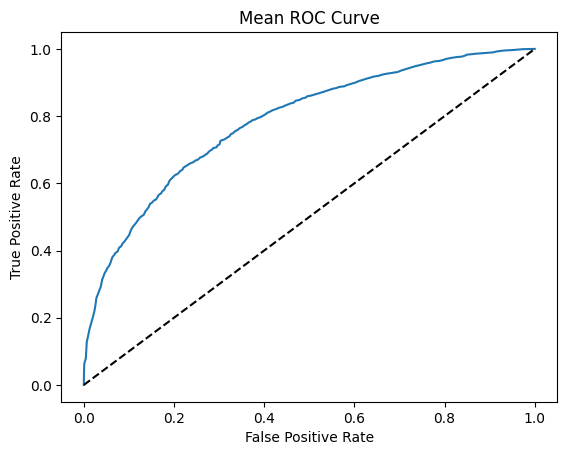

In [196]:
def get_mean_stat(stats, stat_name):
    if stat_name in ["fpr", "tpr"]:
        # Calculate mean fpr and tpr
        values = [item[stat_name] for item in stats]
        min_len = min(len(value) for value in values)
        interpolated_values = []
        for value in values:
            interpolated = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(value)), value)
            interpolated_values.append(interpolated)
        mean_values = np.array(interpolated_values).mean(axis=0)
        return mean_values
    else:
        # Calculate mean for other stats
        return np.array([item[stat_name] for item in stats]).mean()

print('acc:', get_mean_stat(stats, 'acc'))
print('precision:', get_mean_stat(stats, 'precision'))
print('recall:', get_mean_stat(stats, 'recall'))
print('f1:', get_mean_stat(stats, 'f1'))
print('roc_auc:', get_mean_stat(stats, 'roc_auc'))
print('average_precision:', get_mean_stat(stats, 'average_precision'))
mean_fpr = get_mean_stat(stats, 'fpr')
mean_tpr = get_mean_stat(stats, 'tpr')

plt.plot(mean_fpr, mean_tpr)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve')
plt.show()

In [36]:
# from sklearn.model_selection import train_test_split
#
# reset_random()
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=seed_value)
# train_loader, valid_loader = get_data_loaders(X_train, y_train, X_val, y_val)
#
# model = get_model()
# # summary(model, input_size=(1,9))
# model.train()
#
# train_model((train_loader, valid_loader), model, epochs=50)
#
# get_stats(model, valid_loader)

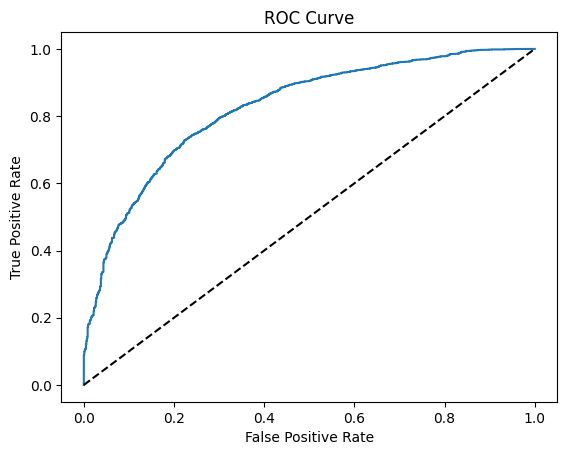

{'acc': 0.8030942334739803,
 'precision': 0.8268912203202651,
 'recall': 0.9336034912718204,
 'f1': 0.87701317715959,
 'roc_auc': 0.8248440512612608,
 'average_precision': 0.929619939519186,
 'conf_matrix': array([[ 431,  627],
        [ 213, 2995]]),
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99716446, 0.99905482,
        1.        ]),
 'tpr': array([0.00000000e+00, 3.11720698e-04, 4.64463840e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00])}

In [147]:
get_stats(model, train_loader)
# def get_mean_stat(stats, stat_name) -> float:
#     return np.array([item[stat_name] for item in stats]).mean()
#
# print('acc:', get_mean_stat(stats, 'acc'))
# print('precision:', get_mean_stat(stats, 'precision'))
# print('recall:', get_mean_stat(stats, 'recall'))
# print('f1:', get_mean_stat(stats, 'f1'))
# print('roc_auc:', get_mean_stat(stats, 'roc_auc'))
# print('average_precision:', get_mean_stat(stats, 'average_precision'))

In [38]:
print(stats)

[{'acc': 0.9113924050632911, 'precision': 0.7931034482758621, 'recall': 0.3898305084745763, 'f1': 0.5227272727272727, 'roc_auc': 0.8430467633244844, 'average_precision': 0.5515609520781786, 'conf_matrix': array([[409,   6],
       [ 36,  23]]), 'fpr': array([0.        , 0.00240964, 0.00240964, 0.00240964, 0.00240964,
       0.00240964, 0.00481928, 0.00481928, 0.00722892, 0.00722892,
       0.01204819, 0.01204819, 0.02168675, 0.02168675, 0.02650602,
       0.02650602, 0.03614458, 0.04096386, 0.04819277, 0.04819277,
       0.05783133, 0.05783133, 0.0626506 , 0.0626506 , 0.10361446,
       0.10361446, 0.1060241 , 0.1060241 , 0.1060241 , 0.11325301,
       0.11325301, 0.11566265, 0.11566265, 0.1373494 , 0.1373494 ,
       0.16385542, 0.16385542, 0.19518072, 0.19518072, 0.24096386,
       0.24096386, 0.24578313, 0.24578313, 0.25783133, 0.25783133,
       0.26024096, 0.26024096, 0.29879518, 0.29879518, 0.37590361,
       0.37590361, 0.37831325, 0.37831325, 0.39036145, 0.39036145,
       0.41

In [39]:
print(model.fc.weight)

Parameter containing:
tensor([[-0.1834,  0.1992,  0.1614,  0.2021, -0.1919, -0.1497, -0.1649,  0.1931,
          0.1388,  0.1923, -0.1795, -0.0877, -0.1934,  0.1432,  0.2017,  0.2008,
         -0.1025,  0.0932, -0.1818, -0.1659, -0.2116, -0.1660, -0.1883,  0.2104,
          0.1997,  0.1497, -0.1900,  0.0996, -0.0915,  0.1924,  0.1212, -0.2179]],
       requires_grad=True)
